In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
#data_file = DATA_PATH + "EPM_test_dict_May_17.pkl"
proj_file = PROJECT_PATH + "c19_epm_projection.csv"
mean_file = PROJECT_PATH + "EPM_Holdout_mean_scores_w_agg.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]



import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()

Mouse0911
Mouse0912
Mouse0913
Mouse0914
Mouse2401
Mouse2402
Mouse2403
Mouse30391
Mouse30392
Mouse3881
Mouse3882
Mouse3883
Mouse69841
Mouse69861
Mouse69862
Mouse69872
Mouse69873


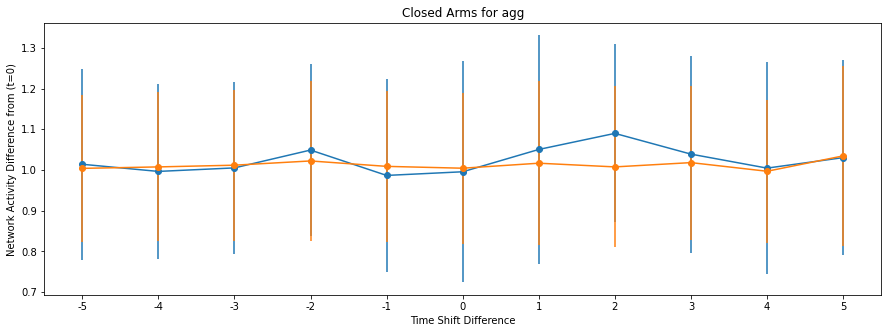

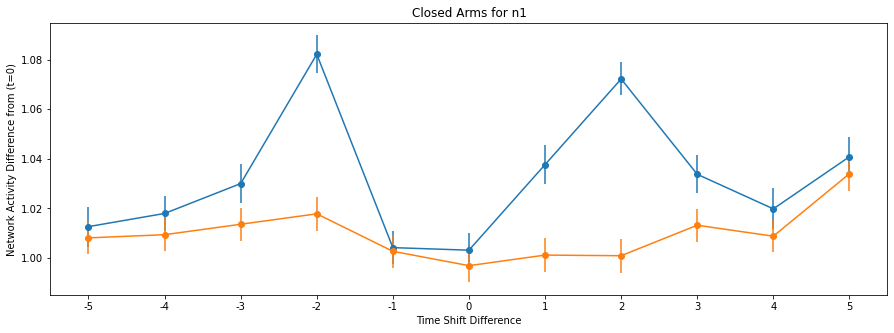

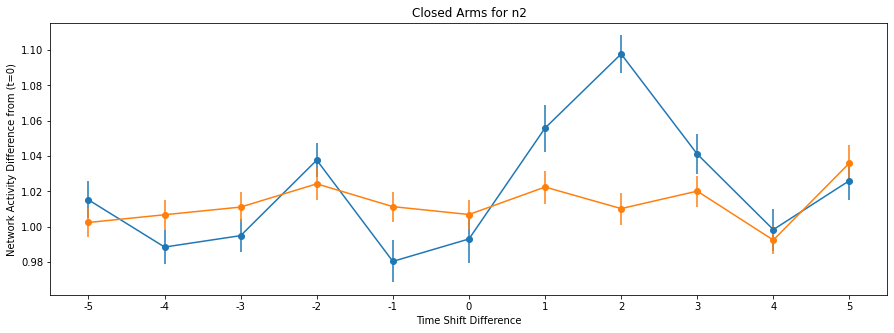

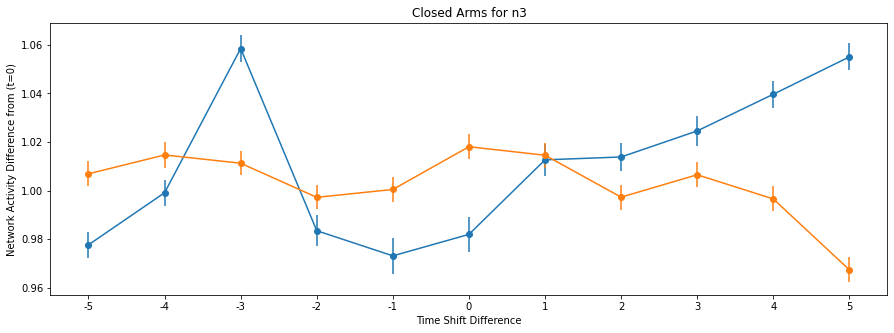

In [3]:
sliding_avg_size=5

allMice_oa_means = []
allMice_ca_means = []

oa_mice_list = []
ca_mice_list = []

oa_geno_list = []
ca_geno_list = []

allDiffs_oa = []
allDiffs_ca = []
for mouse in np.unique(df_in_task.mouse):
    
    print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = df_in_task.roi > 0
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_open_arms = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                                 df_in_task[mask==1]["roi"].values==4)
    
    in_closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                   df_in_task[mask==1]["roi"].values==3)
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    geno = df_in_task[mask==1]["condition"].values[0]
    
    mouse_oa_avgs = []
    mouse_ca_avgs = []
    mouse_avgs = []
    
    oa_centers = []
    ca_centers = []
    all_times = []
    for idx, roi in enumerate(mouse_roi):
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==2 or roi==4: 
                mouse_oa_avgs.append(slice_means)
                oa_centers.append(center_time)
            #if in the closed arms
            elif roi==1 or roi==3: 
                mouse_ca_avgs.append(slice_means)
                ca_centers.append(center_time)
            
    if len(oa_centers) > 0 and mouse!="Mouse69861":
        mouse_oa_slice_mean = np.nanmean(mouse_oa_avgs,axis=0)
        allMice_oa_means.append(mouse_oa_slice_mean)
        oa_mice_list.append(mouse)
        oa_geno_list.append(geno)
    
    if len(ca_centers) > 0 and mouse!="Mouse69861":
        mouse_ca_slice_mean = np.nanmean(mouse_ca_avgs,axis=0)
        allMice_ca_means.append(mouse_ca_slice_mean)
        ca_mice_list.append(mouse)
        ca_geno_list.append(geno)
    
for i, net in zip(range(4),["agg","n1","n2","n3"]):

    plt.figure(figsize=(15,5))
    shared_meanish = np.mean(allMice_oa_means,axis=0)[i][5] / 2 + np.mean(allMice_ca_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    oa_mean = np.mean(allMice_oa_means / shared_meanish,axis=0)
    oa_stderr = np.std(allMice_oa_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),oa_mean[i,:],yerr=oa_stderr[i,:],fmt="-o", label="Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)
    ca_mean = np.mean(allMice_ca_means / shared_meanish ,axis=0)
    ca_stderr = np.std(allMice_ca_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),ca_mean[i,:],yerr=ca_stderr[i,:],fmt="-o", label="Closed Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Closed Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.show()

In [4]:
oa_mouse_segments = []
ca_mouse_segments = []

for i, net in zip(range(4),["agg","n1","n2","n3"]):
    chunk_oa = np.hstack([np.array(oa_mice_list).reshape(-1,1).astype(object),
                          np.array(oa_geno_list).reshape(-1,1).astype(object),
                         np.array([net for _ in range(len(oa_mice_list))]).reshape(-1,1).astype(object),
                         np.array(["OpenArms" for _ in range(len(oa_mice_list))]).reshape(-1,1).astype(object),
                         np.array(allMice_oa_means)[:,i,:]]).astype(object)
    
    chunk_ca = np.hstack([np.array(ca_mice_list).reshape(-1,1).astype(object),
                          np.array(ca_geno_list).reshape(-1,1).astype(object),
                         np.array([net for _ in range(len(ca_mice_list))]).reshape(-1,1).astype(object),
                         np.array(["ClosedArms" for _ in range(len(ca_mice_list))]).reshape(-1,1).astype(object),
                         np.array(allMice_ca_means)[:,i,:]]).astype(object)
    
    oa_mouse_segments.append(chunk_oa)
    ca_mouse_segments.append(chunk_ca)
    

saveData = np.vstack([
                    np.vstack(oa_mouse_segments),
                    np.vstack(ca_mouse_segments)
                    ])

df_save = pd.DataFrame(saveData,columns = ["mouse","geno","network","location"] + list(np.arange(-5,6).astype(str)))
df_save.to_csv(PROJECT_PATH + "OA_vs_CA_11_second_neighborhood_all_nets.csv",index=False)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy.stats import boxcox

mouse_id = []
mouse_name = []
n1_score = []
n2_score = []
location_id = []
geno_id = []
time_id = []
oe = OrdinalEncoder().fit(df_save.mouse.values.reshape(-1,1))


    
for arm in ["OpenArms","ClosedArms"]:
    arm_mask = df_save.location == arm
    
    for mouse in np.unique(df_save.mouse):
        #print(mouse,arm)
        mouse_mask = df_save.mouse==mouse
        
        
        mask = np.logical_and(arm_mask,mouse_mask)
        
        if np.sum(mask) > 0:
            geno_id.append(np.array([1 if df_save[mouse_mask==1].geno.values[0]=="WT" else 0 for _ in range(11)]))
            mouse_id.append(oe.transform(np.array([mouse for _ in range(11)]).reshape(-1,1)).squeeze()+1)
            mouse_name.append([mouse for _ in range(11)])
            location_id.append(np.ones(11) if arm =="OpenArms" else np.zeros(11))
            time_id.append(np.arange(1,12))

            n1_net_mask = df_save.network=="n1"
            n2_net_mask = df_save.network=="n2"

            n1_mask = np.logical_and(mask,n1_net_mask)
            n2_mask = np.logical_and(mask,n2_net_mask)

            n1_score.append(df_save[n1_mask==1][list(np.arange(-5,6).astype(str))].values.astype(float))
            n2_score.append(df_save[n2_mask==1][list(np.arange(-5,6).astype(str))].values.astype(float))
        

stats_df = pd.DataFrame({"mouse":np.array(mouse_id).flatten(),
                         "mouse-name":np.array(mouse_name).flatten(),
                         "time":np.array(time_id).flatten().astype(float),
                         "geno":np.array(geno_id).flatten().astype(float),
                         "openArms":np.array(location_id).flatten(),
                         "bxcx_n1_scores":boxcox(np.array(n1_score).flatten())[0],
                         "bxcx_n2_scores":boxcox(np.array(n2_score).flatten())[0],
                         "n1_scores":np.array(n1_score).flatten(),
                         "n2_scores":np.array(n2_score).flatten(),
                        })

first_five_stats_df = stats_df[stats_df.time<6].copy()
first_five_stats_df["bxcx_n1_scores"] = boxcox(first_five_stats_df.n1_scores.values)[0]
first_five_stats_df["bxcx_n2_scores"] = boxcox(first_five_stats_df.n2_scores.values)[0]

last_five_stats_df = stats_df[stats_df.time>6].copy()
last_five_stats_df["bxcx_n1_scores"] = boxcox(last_five_stats_df.n1_scores.values)[0]
last_five_stats_df["bxcx_n2_scores"] = boxcox(last_five_stats_df.n2_scores.values)[0]

#stats_df.to_csv(PROJECT_PATH + "EPM_11s_window_stats_struct.csv",index=0)
#last_five_stats_df.to_csv(PROJECT_PATH + "last_5_EPM_11s_window_stats_struct.csv",index=0)
#first_five_stats_df.to_csv(PROJECT_PATH + "first_5_EPM_11s_window_stats_struct.csv",index=0)

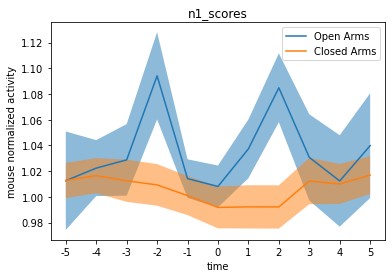

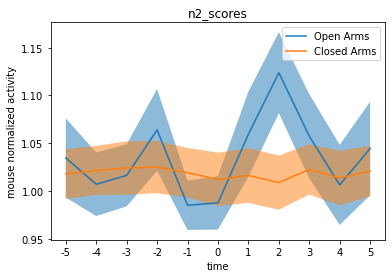

In [7]:

for score_type in ["n1_scores","n2_scores"]:
    oa_scores = []
    ca_scores = []
    t6_oa = []
    t6_ca = []
    for mouse in np.unique(stats_df.mouse):
        mouse_oa_mask = np.logical_and(stats_df.mouse==mouse,
                                       stats_df.openArms==1)
        mouse_ca_mask = np.logical_and(stats_df.mouse==mouse,
                                   stats_df.openArms==0)
        
        if np.sum(mouse_oa_mask) > 0 and np.sum(mouse_ca_mask) > 0:
            six_point_oa = stats_df[mouse_oa_mask==1][score_type].values[5]
            six_point_ca = stats_df[mouse_ca_mask==1][score_type].values[5]
            six_point_mean = np.mean([six_point_oa,six_point_ca])

            oa_scores.append(stats_df[mouse_oa_mask==1][score_type].values / six_point_mean)#/ stats_df[np.logical_and(mouse_oa_mask,
                                                                                                    #stats_df.time==6)]["bxcx_n1_scores"])
            ca_scores.append(stats_df[mouse_ca_mask==1][score_type].values / six_point_mean)  #/ stats_df[np.logical_and(mouse_ca_mask,

    
    
    oa_scores = np.array(oa_scores)
    oa_mean = np.mean(oa_scores,axis=0)
    oa_std = np.std(oa_scores,axis=0) / np.sqrt(11)

    ca_scores = np.array(ca_scores)
    ca_mean = np.mean(ca_scores,axis=0) 
    ca_std = np.std(ca_scores,axis=0) / np.sqrt(11)
    #print(wilcoxon(oa_scores[:,5],ca_scores[:,6]))
    
    plt.plot(oa_mean,label="Open Arms")
    plt.fill_between(range(11),oa_mean+oa_std,oa_mean-oa_std,alpha=0.5)
    plt.plot(ca_mean,label="Closed Arms")
    plt.fill_between(range(11),ca_mean+ca_std,ca_mean-ca_std,alpha=0.5)
    plt.xticks(range(11),np.arange(11) - 5)
    plt.xlabel('time')
    plt.ylabel('mouse normalized activity')
    plt.title(score_type)
    plt.legend()
    plt.show()

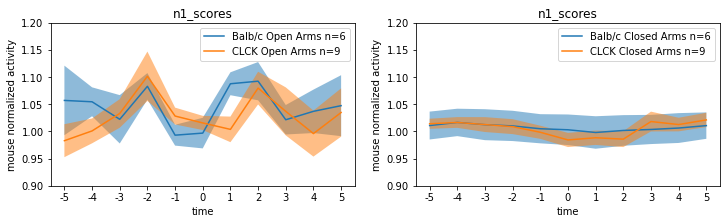

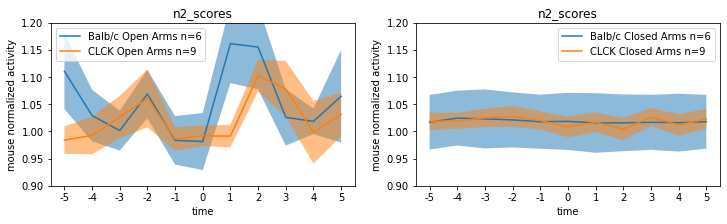

In [8]:

for score_type in ["n1_scores","n2_scores"]:
    clck_oa_scores = []
    clck_ca_scores = []

    wt_oa_scores = []
    wt_ca_scores = []
    for mouse in np.unique(stats_df.mouse):
        
        mouse_oa_mask = np.logical_and(stats_df.mouse==mouse,
                                       stats_df.openArms==1)
        mouse_ca_mask = np.logical_and(stats_df.mouse==mouse,
                                   stats_df.openArms==0)
        
        if np.sum(mouse_oa_mask) > 0 and np.sum(mouse_ca_mask) > 0:
            six_point_oa = stats_df[mouse_oa_mask==1][score_type].values[5]
            six_point_ca = stats_df[mouse_ca_mask==1][score_type].values[5]
            six_point_mean = np.mean([six_point_oa,six_point_ca])
            
            if stats_df[mouse_oa_mask==1]["geno"].values[0]==1:
                
                wt_oa_scores.append(stats_df[mouse_oa_mask==1][score_type].values / six_point_mean)#/ stats_df[np.logical_and(mouse_oa_mask,
                                                                                                        #stats_df.time==6)]["bxcx_n1_scores"])
                wt_ca_scores.append(stats_df[mouse_ca_mask==1][score_type].values / six_point_mean)  #/ stats_df[np.logical_and(mouse_ca_mask,
                
            else:
                clck_oa_scores.append(stats_df[mouse_oa_mask==1][score_type].values / six_point_mean)#/ stats_df[np.logical_and(mouse_oa_mask,
                                                                                                        #stats_df.time==6)]["bxcx_n1_scores"])
                clck_ca_scores.append(stats_df[mouse_ca_mask==1][score_type].values / six_point_mean)  #/ stats_df[np.logical_and(mouse_ca_mask,

    
    
    wt_oa_scores = np.array(wt_oa_scores)
    wt_oa_mean = np.mean(wt_oa_scores,axis=0)
    wt_oa_std = np.std(wt_oa_scores,axis=0) / np.sqrt(len(wt_oa_scores))

    clck_oa_scores = np.array(clck_oa_scores)
    clck_oa_mean = np.mean(clck_oa_scores,axis=0)
    clck_oa_std = np.std(clck_oa_scores,axis=0) / np.sqrt(len(clck_oa_scores))
    
    wt_ca_scores = np.array(wt_ca_scores)
    wt_ca_mean = np.mean(wt_ca_scores,axis=0) 
    wt_ca_std = np.std(wt_ca_scores,axis=0) / np.sqrt(len(wt_ca_scores))
    
    clck_ca_scores = np.array(clck_ca_scores)
    clck_ca_mean = np.mean(clck_ca_scores,axis=0) 
    clck_ca_std = np.std(clck_ca_scores,axis=0) / np.sqrt(len(clck_ca_scores))
    #print(wilcoxon(oa_scores[:,5],ca_scores[:,6]))
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.plot(wt_oa_mean,label="Balb/c Open Arms n=6")
    plt.fill_between(range(11),wt_oa_mean+wt_oa_std,wt_oa_mean-wt_oa_std,alpha=0.5)
    
    plt.plot(clck_oa_mean,label="CLCK Open Arms n=9")
    plt.fill_between(range(11),clck_oa_mean+clck_oa_std,clck_oa_mean-clck_oa_std,alpha=0.5)
    
    plt.xticks(range(11),np.arange(11) - 5)
    plt.xlabel('time')
    plt.ylabel('mouse normalized activity')
    plt.title(score_type)
    plt.legend()
    plt.ylim([0.9,1.20])
    #plt.xlim([3,8])

    plt.subplot(1,2,2)
    plt.plot(wt_ca_mean,label="Balb/c Closed Arms n=6")
    plt.fill_between(range(11),wt_ca_mean+wt_ca_std,wt_ca_mean-wt_ca_std,alpha=0.5)
    
    plt.plot(clck_ca_mean,label="CLCK Closed Arms n=9")
    plt.fill_between(range(11),clck_ca_mean+clck_ca_std,clck_ca_mean-clck_ca_std,alpha=0.5)
    
    plt.xticks(range(11),np.arange(11) - 5)
    plt.xlabel('time')
    plt.ylabel('mouse normalized activity')
    plt.title(score_type)
    plt.legend()
    plt.ylim([0.9,1.20])
    #plt.xlim([3,8])
    plt.show()

In [86]:
print(len(clck_oa_scores))

9


In [87]:
print(len(wt_oa_scores))

7
